G. Nordin<br>
October 14, 2016

# Purpose

We need to accurately measure the image plane optical irradiance of the layer exposure images for the 3D printer we are developing. In the current implemenation, the pixel pitch in the image plane is ~7.6 $\mu$m since the DMD has a micromirror pitch of 7.6 $\mu$m and we are using 1:1 imaging optics. We need to measure the optical irradiance with a ~0.5 $\mu$m resolution, which is 15x smaller than the pixel pitch. We will place a camera detector array in the image plane to directly measure the irradiance. The problem is that the detector array pixel pitch is 4.2 $\mu$m, which is 8.4x larger than our desired resolution. To obtain the desired resolution we apply a super resolution technique in which the detector array is moved in sub-pixel (i.e, sub-detector pixel) increments to collect a series of low resolution images. These images will be processed to construct a high resolution (~0.5 $\mu$m) image. 

Surveying the literature, there are many papers on super resolution techniques. However, they largely focus on more complex situations. Examples include low-resolution images in which the relative lateral displacements are unknown and must be estimated, moving objects within the images, and non-ideal imaging optics. Our case is more straightforward in that it involves:

- Known lateral displacements for the low resolution images
- Grayscale images (i.e., not color)
- Static image scenes (no motion within a scene)
- Lack of optical system non-idealities (blur, distortion, etc.) since the optical images are collected directly on the camera detector array

This Jupyter notebook documents an iterative approach to obtaining super resolution for our limited problem space based on the following paper:

__Improving Resolution by Image Registration__<br>
Michal Irani AND Shmuel Peleg<br>
CVGIP: Graphical Models and Image Processing<br>
Vol. 53, No. 3, May, pp. 231-239, 1991<br>
file: "_1991 IRANI.pdf_"

The notebook also has a series of example super resolution calculations.

# Approach

## Formalism

The main result we use from the paper is embodied in Equation 4:

$$f^{(n+1)}(\boldsymbol{x}) = f^{(n)}(\boldsymbol{x}) + \sum_{i=1}^K{[g_k(\boldsymbol{y}) - g_k^{(n)}(\boldsymbol{y})]\frac{(h_{xy}^{BP})^2}{c\sum{h_{xy'}^{BP}}}}.$$

Assume an ideal image, $F(\boldsymbol{x})$, where $\boldsymbol{x}$ indicates the space in which the image is sampled with the desired sampling resolution (hereinafter referred to as high-resolution). This ideal image is sampled at low resolution by a detector array shifted by known lateral displacements, thereby generating a set of low resolution images, $g_k(\boldsymbol{y})$. Here $\boldsymbol{y}$ indicates the the space in which the images are sampled with the (low) resolution of the detector array. The unique lateral offset of each image is expected to be smaller than the pixel size of the detector array, and are in that sense sub-pixel lateral motions.

Our goal is to obtain an accurate estimate, $F'(\boldsymbol{x})$, for $F(\boldsymbol{x})$ based on the set of low resolution images $g_k(\boldsymbol{y})$. Equation 4 represents an iterative method of obtaining this estimate. It begins with an initial guess, $f^{(1)}(\boldsymbol{x})$. A set of low resolution images, $g_k^{(1)}(\boldsymbol{y})$, are calculated based on this guess for the same lateral offsets as the actual low resolution images, $g_k(\boldsymbol{y})$. These are used to generate a correction factor (the summed term in Eq. 4) to add to $f^{(1)}(\boldsymbol{x})$ to generate a new estimate, $f^{(2)}(\boldsymbol{x})$. The process then repeats in which $f^{(2)}(\boldsymbol{x})$ is used to calculate a new set of low resolution images, $g_k^{(2)}(\boldsymbol{y})$, etc.

The term $h_{xy}^{BP}$ represents non-idealities of the camera's optical system. Our camera has no optical system (i.e., no lens) so we can therefore set $h_{xy}^{BP}$ to one. The term $c$ represents an arbitrary constant. Note that it controls the magnitude of the correction factor applied to the current image estimate, $f^{(n)}(\boldsymbol{x})$. A larger value of c results in a smaller correction factor for each iteration, and vice versa. This affects how rapidly the image estimates $f^{(n+1)}(\boldsymbol{x})$ converge toward $F(\boldsymbol{x})$, and whether there is stable convergence.

Note also that the correction factor in Eq. 4 is in terms of the detector array sample space $\boldsymbol{y}$, which must be converted to the high resolution image sample space $\boldsymbol{x}$ before the correction factor can be applied. The approach taken herein to accomplish this is to re-sample the $g_k(\boldsymbol{y})$ and $g_k^{(n)}(\boldsymbol{y})$ in $\boldsymbol{x}$, thereby forming $g_k(\boldsymbol{x})$ and $g_k^{(n)}(\boldsymbol{x})$, and using these re-sampled images to calculate the correction factor. The actual implementation accomplishes this effect in a slightly streamlined way: 

1. For each $k$ calculate $g_k^{(n)diff}(\boldsymbol{y}) = g_k(\boldsymbol{y}) - g_k^{(n)}(\boldsymbol{y})$
1. Re-sample the low resolution $g_k^{(n)diff}(\boldsymbol{y})$ to obtain a high resolution $g_k^{(n)diff}(\boldsymbol{x})$
1. Then calculate the correction factor, $s^{(n)}(\boldsymbol{x}) = \frac{1}{c}\sum_{i=1}^K{g_k^{(n)diff}(\boldsymbol{x})}$

## Implementation

To test this algorithm, 

1. Generate an arbitrary test image, $F(\boldsymbol{x})$
1. Define a set of offsets
1. Calculate a set of low resolution images, $g_k(\boldsymbol{y})$, one for each offset

Given the offsets and low resolution images, 

1. Calculate a starting guess, $f^{(1)}(\boldsymbol{x})$, by re-sampling the low resolution images to high resolution and averaging them.
1. Calculate the low res images, $g_k^{(1)}(\boldsymbol{y})$, from $f^{(1)}(\boldsymbol{x})$
1. Calculate $g_k^{(1)diff}(\boldsymbol{y})$
1. Re-sample to obtain $g_k^{(1)diff}(\boldsymbol{x})$
1. Calculate the correction factor $s^{(n)}(\boldsymbol{x})$ and add to $f^{(1)}(\boldsymbol{x})$ to obtain $f^{(2)}(\boldsymbol{x})$
1. Use $f^{(2)}(\boldsymbol{x})$ as the basis for Step 2 and repeat until $s^{(n)}(\boldsymbol{x})$ is smaller than some convergence criterion. I have not yet implemented a convergence criterion, and instead just repeat for a specified number of iterations.

## Definitions and relationships

1. High resolution images are N x N pixels
1. Low resolution images are M x M pixels
1. Number of high resolution pixels per low resolution pixel is R = N/M
1. Lateral image offsets are specified in terms of high resolution pixels and are in the range [0, R-1] in each dimension
1. In the final high resolution image estimate, $F'(\boldsymbol{x})$, the outer edges to a width of R pixels (i.e., equivalent to one low resolution pixel) should be ignored because any high resolution pixel estimates in these regions do not benefit from all of the low resolution image information because of the low resolution image lateral shifts.


# To-do

## Implementation

1. &#9989; 10/14/16; Clip values in each newly-calculated $f^{(n+1)}(\boldsymbol{x})$ to be in the range [0.0, 1.0] (otherwise there will typically be negative pixel values)
1. &#9989; 10/15/16; Develop utility functions to visualize positive and negative grayscale values using colors
  1. Let postive values be green and negative values red
  1. Make a function to convert a grayscale image with values in the range [-1.0, 1.0] to RGB images with values in the range [0.1 - 1.0] for each color channel. Positive grayscale image values go into the green channel, negative into the red (after changing their sign) and the blue channel stays zero.
1. &#9989; 10/14/16 (for now, just look at min and max pixel value difference between original and final image); Develop a standard way of quantifying how different a final image estimate is compared to the starting test image
1. Write a more general multi-image display function in which the images are automatically layed out in an m x n grid

## Explore algorithm capabilities

1. For a given pixel size for high and low resolution images, try different numbers of low resolution images and different distributions of their lateral offsets
  1. The maximum number of unique lateral offsets is R$^2$. What fraction of these possibilities (i.e., L$_{low-res}$/R$^2$ where L$_{low-res}$ is the number of low resolution images) and their distribution (randomly selected from R$^2$?) gives the best convergence and image estimate accuracy?
1. Try different high and low resolution image sizes, i.e., N, M, and R
1. Evaluate how big or small c should be for a given number of low resolution images
  1. Presumably it will be inversely related to L$_{low-res}$/R$^2$
1. Try different binary (i.e, pixel values of only 0 and 1) test images
  1. Pay attention to features with different sizes, both sub-pixel and larger than a pixel (i.e., relative to detector array pixel size)
1. Try different grayscale (i.e., pixel values in the range [0.0, 1.0]) test images
  1. Pay attention to features with different sizes, both sub-pixel and larger than a pixel (i.e., relative to detector array pixel size)

## Bonus tasks

1. Develop a machine learning algorithm to answer the questions above given the image plane intensity distribution we expect to observe (calculated using something like the angular spectrum method).

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Super resolution algorithm and image manipulation functions

In [2]:
#----------------------------------------------------------------------
# Definition functions
#----------------------------------------------------------------------

def define_pixel_relations(LRpix = 8, HRpix_per_LRpix = 5):
    """
    Return dict with low-res and hi-res image information
    
    LRpix - Size of low-res images in pixels, i.e., (LRpix x LRpix)
    HRpix - Size of hi-res images in pixels, i.e., (HRpix x HRpix)
    HRpix_per_LRpix - Number of hi-res pixels per low-res pixel, 
                      i.e., one low-res pixel is 
                      (HRpix_per_LRpix x HRpix_per_LRpix) hi-res pixels
    """
    return {"LRpix" : LRpix, 
            "HRpix_per_LRpix" : HRpix_per_LRpix,
            "HRpix" : (LRpix + 1) * HRpix_per_LRpix
           }


#----------------------------------------------------------------------
# Image functions
#----------------------------------------------------------------------

def make_hires_test_image(pix, case=1):
    """
    Make a hi-res test image given the pixel values in `pix` for the specified case
    
    Arguments:
      pix - pixel relationships returned by the function `define_pixel_relations()`
      case - pick a specific test image
    
    Returns:
      hi-res HRpix x HRpix pixel image
    """
    testHR = np.zeros((pix["HRpix"],pix["HRpix"]), dtype=float)
    if case == 1:
        if pix["HRpix"] >= 30:
            testHR[5:10, 10:15] = 1
            testHR[5:10, 25:26] = 1
            testHR[5:6, 25:30] = 1
            testHR[15:20, 15:20] = 1
        if pix["HRpix"] >= 40:
            testHR[25:35, 25:35] = 1
    elif case == 2:
        sx = int(testHR.shape[0]/9)
        sy = int(testHR.shape[1]/9)
        circ(testHR, 2*sx+1, 2*sy+1, min(sx,sy))
        circ(testHR, 3*sx+1, 3*sy+2, int(1.2*min(sx,sy)))
        circ(testHR, 6*sx-1, 6*sy-1, 2*min(sx,sy))
        circ(testHR, 5*sx+5, 5*sy+5, min(sx,sy), value=0.0)
        rect(testHR, 2*sx+2, 6*sy, sx+1, 2*sy+2)
        rect(testHR, 6*sx+1, 2*sy+1, 3*sx+1, 2*sy+1)
        rect(testHR, 6*sx, 2*sy, 2*sx, sy, value=0.0)
    else:
        raise ValueError('No test image case defined for input value of {}'.format(case))
    return testHR

def make_lowres_image(pix, imageHR, offset = (0,0)):
    """
    Make a low-res image from a hi-res image
    
    Arguments:
      pix - pixel relationships returned by the function `define_pixel_relations()`
      imageHR - original hi-res image to downsample (decimate)
      offset - how many x-y hi-res pixels to offset the generated low-res image
      
    Returns:
      low-res image in a 2D numpy array
    """
    imageLR = np.zeros((pix["LRpix"],pix["LRpix"]), dtype=float)
    # Set up x
    xHR_min = offset[0]
    xHR_max = pix["LRpix"]*pix["HRpix_per_LRpix"] + xHR_min
    xHR_interval = pix["HRpix_per_LRpix"]
    # Set up y
    yHR_min = offset[1]
    yHR_max = pix["LRpix"]*pix["HRpix_per_LRpix"] + yHR_min
    yHR_interval = pix["HRpix_per_LRpix"]
    # Loop over y (jj)
    for jj in range(yHR_min, yHR_max, yHR_interval):
        jj_limit = min(jj+yHR_interval, pix["HRpix"])
        jLR = int((jj-yHR_min)/yHR_interval)
        # Loop over x (ii)
        for ii in range(xHR_min, xHR_max, xHR_interval):
            ii_limit = min(ii+xHR_interval, pix["HRpix"])
            iLR = int((ii-xHR_min)/xHR_interval)
            imageLR[jLR,iLR] = np.average(imageHR[jj:jj_limit, ii:ii_limit])
    return imageLR

def make_highres_version_of_lowres(pix, lowres, offset, value=np.nan):
    """
    Return a hi-res version of the input low-res image, `lowres`
    
    Arguments:
      pix - pixel relationships returned by the function `define_pixel_relations()`
      lowres - original low-res image to upsample by copying each low-res pixel value
               to the corresponding block of high-res pixels
      offset - how many x-y hi-res pixels to offset the generated low-res image
      value - for border pixel values; default is NaN
      
    Returns:
      high-res image in a 2D numpy array    
    """
    highres = np.full((pix["HRpix"], pix["HRpix"]), value, dtype=float)
    for jj in range(pix["LRpix"]):
        jj_min = offset[1] + jj*pix["HRpix_per_LRpix"]
        jj_max = jj_min + pix["HRpix_per_LRpix"]
        for ii in range(pix["LRpix"]):
            ii_min = offset[0] + ii*pix["HRpix_per_LRpix"]
            ii_max = ii_min + pix["HRpix_per_LRpix"]
            highres[jj_min:jj_max, ii_min:ii_max] = lowres[jj,ii]
    return highres

def circ(a, c_h, c_v, r, value=1.0):
    for jj in range(c_v-r,c_v+r):
        for ii in range(c_h-r,c_h+r):
            if (jj-c_v)**2 + (ii-c_h)**2 < r**2:
                a[jj,ii] = value
                
def rect(a, c_h, c_v, w, h, value=1.0):
    wd2 = int(w/2)
    hd2 = int(h/2)
    for jj in range(c_v-hd2, c_v+hd2):
        for ii in range(c_h-wd2, c_h+wd2):
            a[jj,ii] = value

def convert_to_RGB(a):
    out = np.zeros((a.shape[0], a.shape[1], 3), dtype="float32")
    out[:,:,0] = -np.clip(a, -1, 0)
    out[:,:,2] = np.clip(a, 0, 1)
    return out


#----------------------------------------------------------------------
# Super resolution algorithm functions
#----------------------------------------------------------------------


def make_test_image_dataset(pix, offsets, case=1):
    """
    Make a test image dataset for given `pix` and list of offsets
    
    Arguments:
    
      pix - pixel relationships returned by the function `define_pixel_relations()`
      offsets - list of offset tuples, e.g., [(0,0), (0,3), (1,2), (4,4)]
    
    Returns:
    
      dict that contains the following key value pairs:
        pix : argument
        offsets : argument
        original : a hi-res test image
        lowres : list of low-res images of the hi-res test image, one for each offset
        highres : hi-res versions of the low-res images, one for each offset
        guess : hi-res image of average of images in highres list
    """
    test_image = make_hires_test_image(pix, case)
    lowres_images = [make_lowres_image(pix, test_image, offset = o) for o in offsets]
    highres_images = [make_highres_version_of_lowres(pix, lowres, offset) 
                      for lowres, offset in zip(lowres_images, offsets)]
    # Make average image of `highres_images`
    guess_image = np.zeros((test_image.shape[0], test_image.shape[1]), dtype=float)
    for image in highres_images:
        temp = np.copy(image)
        temp[np.isnan(temp)] = 0
        guess_image += temp
    guess_image /= len(highres_images)
    # End make average image
    return {"pix" : pix,
            "offsets" : offsets,
            "original" : test_image,
            "lowres" : lowres_images,
            "highres" : highres_images,
            "guess" : guess_image
           }

def add_new_elements_to_dict(t):
    t["iter_lowres"] = [ t["lowres"] ]
    t["iter_diff_lowres"] = [ None ]
    t["iter_diff_highres"] = [ None ]
    t["iter_sum_diff_highres"] = [ None ]
    t["estimated_images"] = [ t["guess"] ]

def initialize_prior_to_making_estimates(t):
    t["iter_count"] = 0
    
def initialize_c(t, value):
    t["c"] = float(value)

def make_new_estimated_image(t, clip_range=False):
    t["iter_count"] += 1
    i = t["iter_count"]
    
    # Make iter_lowres
    t["iter_lowres"].append( 
        [make_lowres_image(t["pix"], t["estimated_images"][i-1], offset = o) for o in t["offsets"]] )
    
    # Make iter_diff_lowres
    temp_diff = []
    for a,b in zip(t["iter_lowres"][0],t["iter_lowres"][i]):
        temp_diff.append(a-b)
    t["iter_diff_lowres"].append( temp_diff )
    
    # Make iter_diff_highres
    temp_diff_highres = [make_highres_version_of_lowres(t["pix"], lowres, offset, value=0.0) 
                         for lowres, offset in zip(temp_diff, t["offsets"])]
    t["iter_diff_highres"].append( temp_diff_highres )
    
    # Make sum of differences
    temp_sum = np.copy(temp_diff_highres[0])
    for index in range(1,len(temp_diff_highres)):
        temp_sum += temp_diff_highres[index]
    #print("    ", i, "Sum of diffs min/max:", np.min(temp_sum), np.max(temp_sum))
    t["iter_sum_diff_highres"].append( temp_sum )
    
    # Make new estimated image
    t["estimated_images"].append( t["estimated_images"][i-1] + temp_sum/t["c"] )
    if clip_range:
        np.clip(t["estimated_images"][i], 0, 1, out=t["estimated_images"][i])
    #print("    ", i, "Estimated image min/max:", np.min(t["estimated_images"][i]), np.max(t["estimated_images"][i]))

def print_lengths(t):
    keys = ["iter_lowres", 
            "iter_diff_lowres",
            "iter_diff_highres",
            "iter_sum_diff_highres",
            "estimated_images",
           ]
    for key in keys:
        print( "{}: {}".format( key, len( t[key] ) ), "  ", *[type(a) for a in t[key]] )

def calc_superresolution(LRpix, HRpix_per_LRpix, offsets, c, n_iterations, case=1):
    
    # Define pix information
    temp_pix = define_pixel_relations(LRpix, HRpix_per_LRpix)
    
    # Initialize dict with test case
    t = make_test_image_dataset(temp_pix, offsets, case)
    add_new_elements_to_dict(t)
    initialize_prior_to_making_estimates(t)
    initialize_c(t, c)
    
    # Iterate to calculate super-resolution image
    for index in range(n_iterations):
        #print(index, t["iter_count"])
        make_new_estimated_image(t, clip_range=True)
    
    # Calculate original - result difference image
    t["diff_image"] = t["original"] - t["estimated_images"][-1]
    t["diff_image_min"] = np.min(t["diff_image"])
    t["diff_image_max"] = np.max(t["diff_image"])
    t["diff_image_min_index"] = np.unravel_index(t["diff_image"].argmin(), t["diff_image"].shape)
    t["diff_image_max_index"] = np.unravel_index(t["diff_image"].argmax(), t["diff_image"].shape)
    t["diff_image_color"] = convert_to_RGB(t["diff_image"])
    t["diff_image_color_normalized"] = t["diff_image_color"]/np.max(t["diff_image_color"])

    return t


#----------------------------------------------------------------------
# Utility functions
#----------------------------------------------------------------------

def show_results(t):
    if t["iter_count"] == 0:
        raise ValueError('No iterations have been run')
        
    HRpix = t["pix"]["HRpix"]
    LRpix = t["pix"]["LRpix"]
    HRpix_per_LRpix = t["pix"]["HRpix_per_LRpix"]
    print("          Original image: {} x {} pixels".format(HRpix, HRpix))
    print("   Low resolution images: {} x {} pixels".format(LRpix, LRpix))
    print("     One low-res pixel is {} x {} hi-res pixels".format(HRpix_per_LRpix, HRpix_per_LRpix))
    print("Number of low-res images:", len(t["lowres"]))
    print("    Number of iterations:", t["iter_count"])
    print("                       c:", t["c"], "\n")
    print("Estimated image min and max:", np.min(t["estimated_images"][-1]), np.max(t["estimated_images"][-1]))
    print_diff_min_max(t)
    temp_titles = ["Original",
              "Initial Guess",
              "Final"
             ]
    show_image_list( [ t["original"], t["guess"], t["estimated_images"][-1] ], 
                    show_grid_lines=False,
                    titles = temp_titles
                   )

def print_diff_min_max(t):
    print("Min & max pixel differences, original - estimated:", t["diff_image_min"], t["diff_image_max"])
    print("                                               at:", t["diff_image_min_index"],
                                                                t["diff_image_max_index"])    

#     diff_t = t["original"] - t["estimated_images"][-1]
#     print("Min & max pixel differences, original - estimated:", np.min(diff_t), np.max(diff_t))
#     print("                                               at:", np.unravel_index(diff_t.argmin(), diff_t.shape),
#                                                                 np.unravel_index(diff_t.argmax(), diff_t.shape))

# Image display functions

In [3]:
def populate_ax_with_image(ax, image_array, show_grid_lines = True):
    """
    Plot `image_array` with specified `ax`
    """
    ax.imshow(image_array, interpolation="none", origin='lower', cmap="Greys_r", vmin=0, vmax=1)
    if show_grid_lines:
        # Minor ticks
        ax.set_xticks(np.arange(-.5, image_array.shape[0], 1), minor=True);
        ax.set_yticks(np.arange(-.5, image_array.shape[1], 1), minor=True);
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

def show_image(image_array, show_grid_lines = True, title = None):
    """
    Plot an image
    """
    fig, ax = plt.subplots(figsize=(6,6))
    populate_ax_with_image(ax, image_array, show_grid_lines)
    #cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical', cmap="Greys_r")

def show_image_list(images, show_grid_lines = True, titles = None):
    """
    Plot images side-by-side in a single row
    """
    n_images = len(images)
    if n_images > 5:
        raise ValueError('More than 4 images in list')
    fig, ax = plt.subplots(ncols=n_images, figsize=(n_images*5,6))
    for index, image in enumerate(images):
        populate_ax_with_image(ax[index], image, show_grid_lines)
    if titles != None:
        if len(titles) != n_images:
            raise ValueError('number of titles does not match number of images in list')
        else:
            for index, title in enumerate(titles):
                ax[index].set_title(title)

def show_image_list_in_col(images, show_grid_lines = True, titles = None):
    """
    Plot images in a single column
    """
    n_images = len(images)
    fig, ax = plt.subplots(nrows=n_images, figsize=(4,n_images*4))
    for index, image in enumerate(images):
        populate_ax_with_image(ax[index], image, show_grid_lines)
    if titles != None:
        if len(titles) != n_images:
            raise ValueError('number of titles does not match number of images in list')
        else:
            for index, title in enumerate(titles):
                ax[index].set_title(title)


def show_diff_image_list(source_dict_list, show_grid_lines = False, titles = None):
    """
    Plot images side-by-side in a single row
    """
    n_plot_columns = len(source_dict_list)
    if n_plot_columns > 5:
        raise ValueError('More than 4 images in list')
    fig, ax = plt.subplots(ncols=n_plot_columns, nrows=2, figsize=(n_plot_columns*4,8))
    for index, d in enumerate(source_dict_list):
        populate_ax_with_image(ax[0,index], d["diff_image"], show_grid_lines)
        populate_ax_with_image(ax[1,index], d["diff_image_color_normalized"], show_grid_lines)
    if titles != None:
        if len(titles) != n_plot_columns:
            raise ValueError('number of titles does not match number of images in list')
        else:
            for index, title in enumerate(titles):
                ax[0,index].set_title(title)
    plt.tight_layout()


# Example Calculations

## Initial cases - smaller numbers of low-res images

Let's start with a small number of low resolution images, namely, 4, and $c = 8$ and 20 iterations.

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 4
    Number of iterations: 20
                       c: 8.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.161058520286 0.355637970069
                                               at: (35, 25) (6, 25)


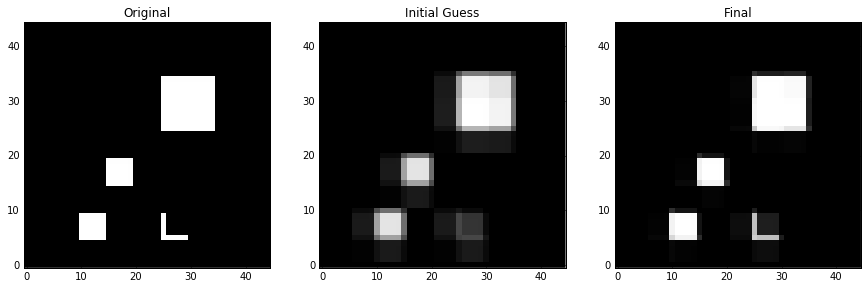

In [4]:
offsets_4 = [ (0,0), (0,1), 
              (1,0), (1,1) ]

t_o4 = calc_superresolution(8, 5, offsets_4, 8, 20)
show_results(t_o4)

Note that the final estimate is remarkably more like the original than the initial guess. To evaluate the quality of the estimate, pay attention to the 2nd to last printed line above the images. The min and max pixel value difference between the original and final images is -0.16 and 0.36, respectively.

Now let's keep the same parameters except use 5 diagonal offset low-res images.

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 5
    Number of iterations: 20
                       c: 8.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.270751042211 0.512443056107
                                               at: (6, 26) (5, 29)


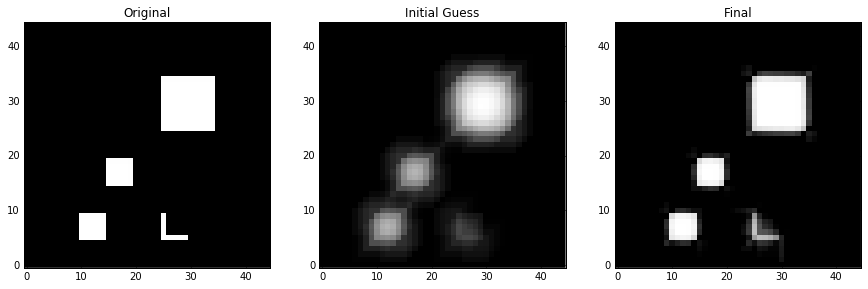

In [5]:
offsets_diag5 = [ (0,0), (1,1), (2,2), (3,3), (4,4) ]

t_d5 = calc_superresolution(8, 5, offsets_diag5, 8, 20)
show_results(t_d5)

Note that the min & max are actually worse.

Now let's try 8 randomly distributed low-res images and increase the iterations to 40.

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 8
    Number of iterations: 40
                       c: 8.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.188430076308 0.273875039118
                                               at: (6, 26) (5, 29)


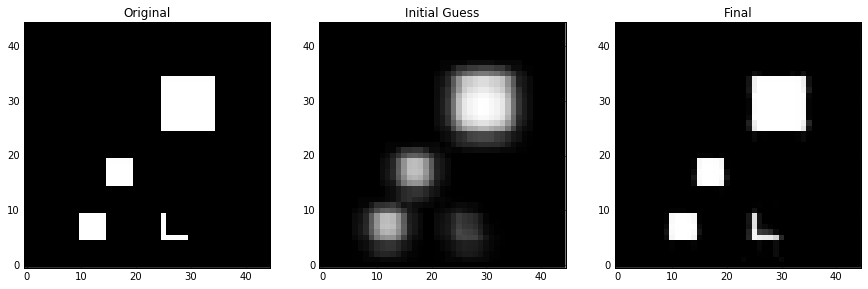

In [6]:
offsets_r8 =   [ (0,0),       (0,2),
                 (1,0), (1,1),
                                    (2,3),
                        (3,1),
                 (4,0),       (4,2)]

t_r8 = calc_superresolution(8, 5, offsets_r8, 8, 40)

show_results(t_r8)

There is a small amount of improvement over the original test case. Let's summarize by looking at the difference images:

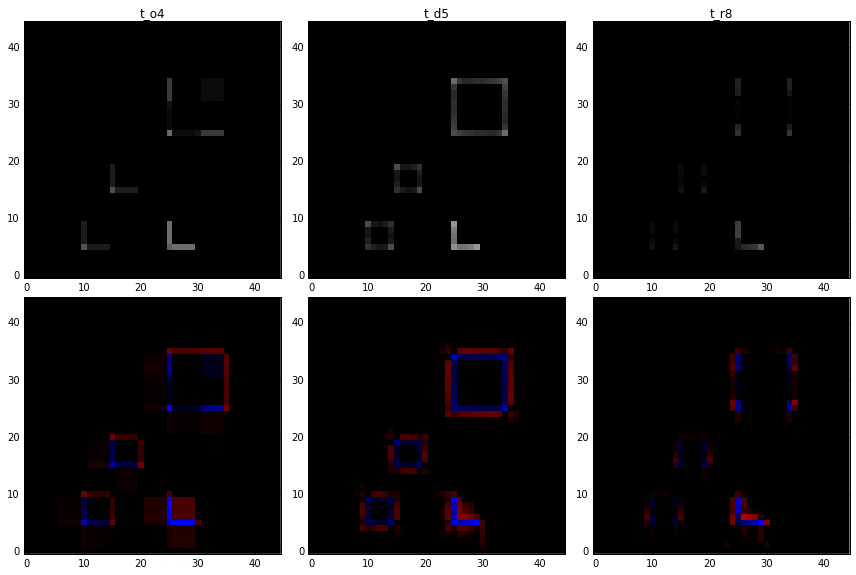

In [7]:
temp_titles = ["t_o4", "t_d5", "t_r8"]
show_diff_image_list([t_o4, t_d5, t_r8], titles=temp_titles)

The top row shows a grayscale image of the original image minus the final image. It only displays positive values, so the relative brightness of a pixel shows how much larger the original image is in that location compared to the final image. The bottom row shows both positive and negative values of the difference image. Postive values (i.e., the original image has a larger pixel value that the final image in that location) are shown in blue, and negative values (i.e., the original image has a smaller pixel value that the final image in that location) are shown in red.

Clearly, the super resolution algorithm has the hardest time reconstructing edges and corners.

## 25 low-resolution images

Let's try the maximum number of sub-pixel displaced low-res images, 25, (i.e., R$^2$) and increase the iterations to 100.

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 100
                       c: 8.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.0216521500822 0.515196658983
                                               at: (35, 25) (9, 25)


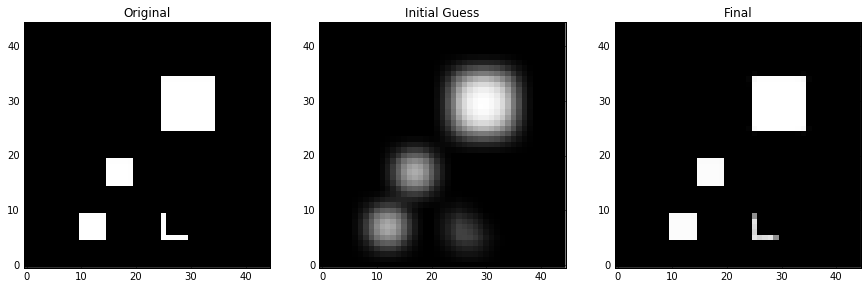

In [8]:
offsets_all25 =  [ (0,0), (0,1), (0,2), (0,3), (0,4),
                (1,0), (1,1), (1,2), (1,3), (1,4),
                (2,0), (2,1), (2,2), (2,3), (2,4),
                (3,0), (3,1), (3,2), (3,3), (3,4),
                (4,0), (4,1), (4,2), (4,3), (4,4) ]

t_o25_c8_i100 = calc_superresolution(8, 5, offsets_all25, 8, 100)
show_results(t_o25_c8_i100)

Note that the min/max are pretty crummy. Increasing $c$ to 15 provides a dramatic improvement:

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 100
                       c: 15.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.124412028253 0.113701603199
                                               at: (6, 26) (9, 25)


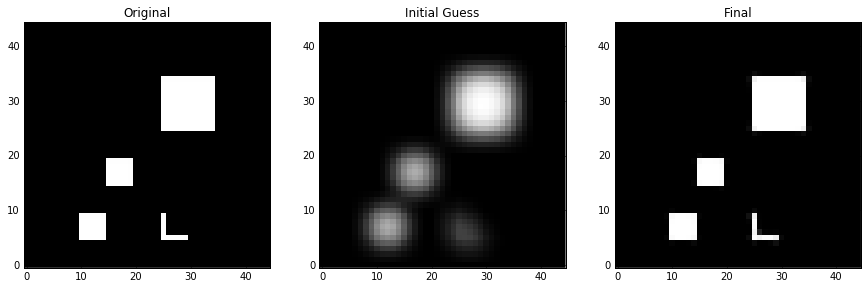

In [9]:
t_o25_c15_i100 = calc_superresolution(8, 5, offsets_all25, 15, 100)
show_results(t_o25_c15_i100)

Decreasing $c$ to 12 gives more improvement:

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 100
                       c: 12.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.104139726212 0.0830802645553
                                               at: (6, 26) (9, 25)


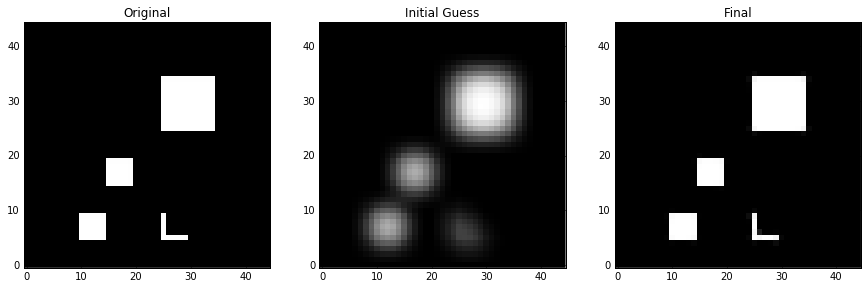

In [10]:
t_o25_c12_i100 = calc_superresolution(8, 5, offsets_all25, 12, 100)
show_results(t_o25_c12_i100)

And decreasing $c$ even further to 10 gives an even better min/max result: -0.09 and 0.06:

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 100
                       c: 10.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.0886774984973 0.0620745047308
                                               at: (6, 26) (9, 25)


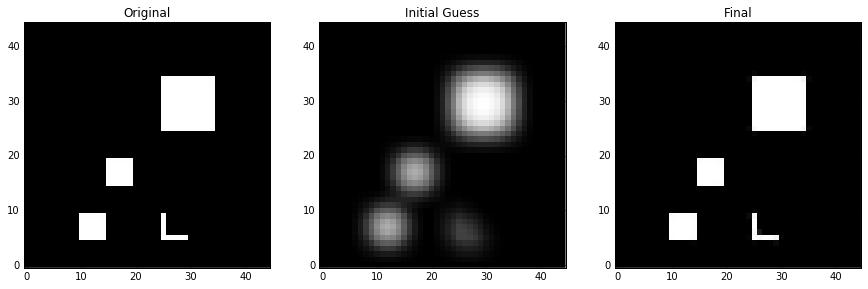

In [11]:
t_o25_c10_i100 = calc_superresolution(8, 5, offsets_all25, 10, 100)
show_results(t_o25_c10_i100)

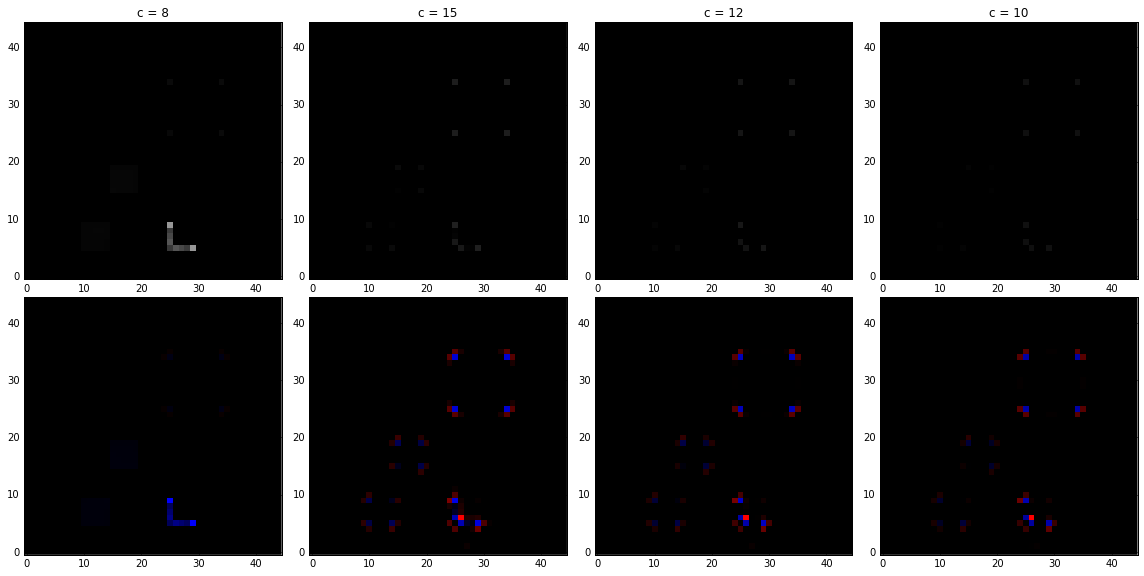

In [12]:
temp_titles = ["c = 8", "c = 15", "c = 12", "c = 10"]
show_diff_image_list([t_o25_c8_i100, t_o25_c15_i100, t_o25_c12_i100, t_o25_c10_i100], titles=temp_titles)

Apparently, the choice of $c$ can have a major effect. Note that for c = 15, 12, and 10 the location of greatest error is inside the corner of the "L" shape where the final image pixel value is larger than the original image pixel value (which is 0).

Now let's see what happens when we increase the number of iterations while keeping c = 10. Let's first go to 200:

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 200
                       c: 10.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.030762501662 0.0203666093984
                                               at: (6, 26) (5, 26)


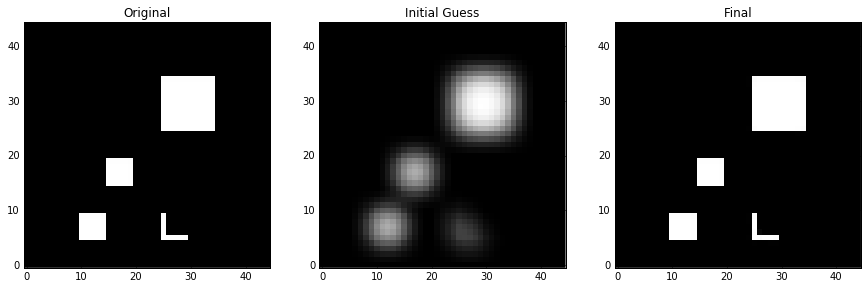

In [13]:
t_o25_c10_i200 = calc_superresolution(8, 5, offsets_all25, 10, 200)
show_results(t_o25_c10_i200)

This is impressive. The min & max are 3% and 2%, respectively. Now, just for fun, let's really crank up the iterations and go to 500:

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 500
                       c: 10.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.00222176344309 0.00170720666824
                                               at: (6, 26) (5, 26)


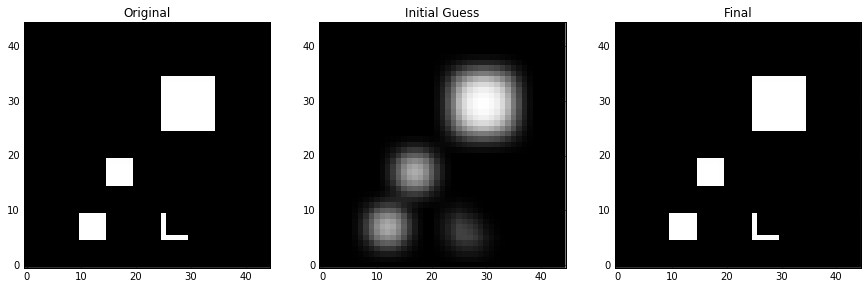

In [14]:
t_o25_c10_i500 = calc_superresolution(8, 5, offsets_all25, 10, 500)
show_results(t_o25_c10_i500)

Wow, the min & max are both around 0.2%! I'm impressed. Note where the min and max deviations occur: as seen below the min error is inside the corner of the elbow where it should be 0.0 but is slightly above that, and the max error is at the elbow itself where it should be 1.0 but is slightly lower

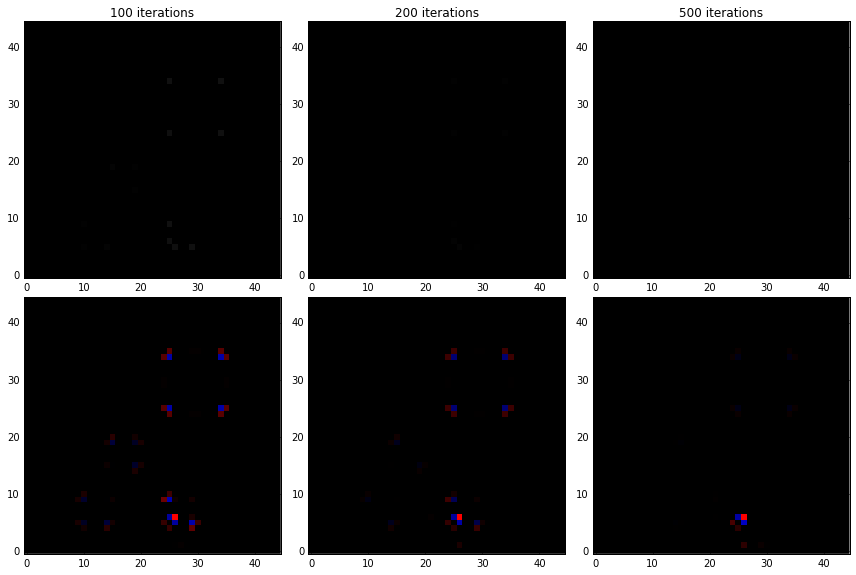

In [15]:
temp_titles = ["100 iterations", "200 iterations", "500 iterations"]
show_diff_image_list([t_o25_c10_i100, t_o25_c10_i200, t_o25_c10_i500], titles=temp_titles)

## Let's use a different test image

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 500
                       c: 10.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.0154561341809 0.0137474496431
                                               at: (21, 21) (21, 20)


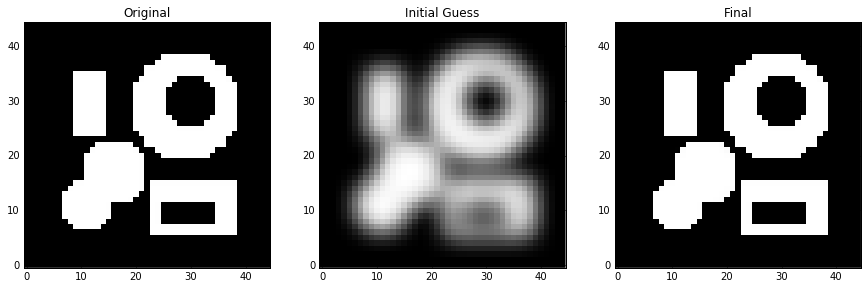

In [16]:
t_o25_c10_i500_case2 = calc_superresolution(8, 5, offsets_all25, 10, 500, case=2)
show_results(t_o25_c10_i500_case2)

The min and max errors are about 1.5%, which is quite good. However, I've fiddled around with other test images and they don't work out so well. Performance appears to be dependent on the initial test image.

Fewer iterations:

          Original image: 45 x 45 pixels
   Low resolution images: 8 x 8 pixels
     One low-res pixel is 5 x 5 hi-res pixels
Number of low-res images: 25
    Number of iterations: 200
                       c: 10.0 

Estimated image min and max: 0.0 1.0
Min & max pixel differences, original - estimated: -0.0933383067075 0.0992784676899
                                               at: (21, 21) (21, 20)


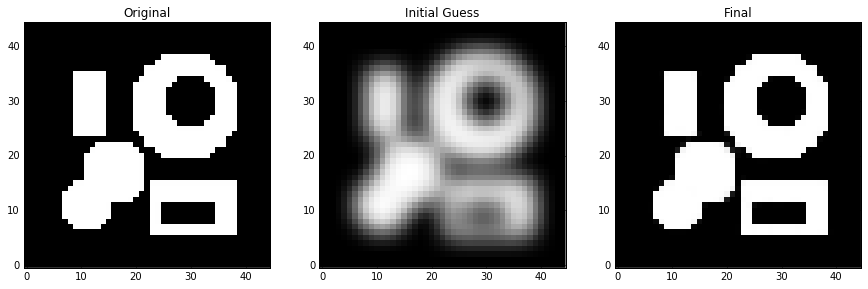

In [17]:
t_o25_c10_i200_case2 = calc_superresolution(8, 5, offsets_all25, 10, 200, case=2)
show_results(t_o25_c10_i200_case2)

Now the biggest errors are in the 9%-10% range.